### Import related package

In [37]:
## Import tensorflow package for modeling
import torch
from torch.autograd import Variable
import torch.optim as optim

## Data processing
import pandas as pd
import numpy as np

## Min-max normalization
from sklearn.preprocessing import MinMaxScaler

## Plot the graph
import matplotlib.pyplot as plt
%matplotlib inline

## Initializing module
from sklearn.linear_model import LinearRegression
np.set_printoptions(suppress=True)

## Copy module
import copy

## Used to calculate the training time
import time

## Set the GUP environment
import os

from matplotlib.ticker import MaxNLocator

In [38]:
## Set up the display
torch.set_printoptions(sci_mode=False)

## 編寫結果在note中

In [39]:
import logging

# Setup logging.
logging.basicConfig(
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%m/%d/%Y %I:%M:%S %p',
    level=logging.DEBUG,
    filename='log.txt'
)

### Control memory usage space for GPU

In [40]:
## 查詢有無可用 GPU
torch.cuda.is_available()
## 查詢可用 GPU 的數量
torch.cuda.device_count()
##目前設備
print("目前設備：",torch.cuda.current_device())
## 目前設備名
print("目前設備名：",torch.cuda.get_device_name(0))

目前設備： 0
目前設備名： GeForce GTX 1070 Ti


In [41]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

In [42]:
# gpus = tf.config.list_physical_devices(device_type='GPU')

# tf.config.set_logical_device_configuration(
#     gpus[0],
#     [tf.config.LogicalDeviceConfiguration(memory_limit=2048),
#      tf.config.LogicalDeviceConfiguration(memory_limit=2048)]
# )

In [43]:
# os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [44]:
# config = tf.compat.v1.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction =0.1
# tf.compat.v1.Session(config=config)

In [45]:
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.5)
# sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))
# tf.compat.v1.keras.backend.set_session(sess)

## Print out some info

In [46]:
def accuracy_cacl(pred_value, actual_value):
    
#     yo, loss, tape = network.forward()
    accuracy = []

    for i in range(pred_value.shape[1]):
        
        correct_times = torch.nonzero(torch.abs(pred_value[:,i] - actual_value[:,i]) < 2000)
        accuracy.append(correct_times.shape[0]/pred_value.shape[0])   
        
    return accuracy

In [47]:
def plot_result(name, pred_value, actual_value):
    
    fig, ax = plt.subplots(2,2,figsize=(20,10), sharex=True, sharey=True)
#     ax.set_xlim(0,pred_value.shape[0])  

    for i in range(yo.shape[1]):
        ax[i//2,i%2].plot(pred_value[:,i], label="LLAAT")
        ax[i//2,i%2].plot(actual_value[:,i], label="Actual")
        ax[i//2,i%2].set_title("Forecasted performance for l=%d" %(i+1))
        ax[i//2,i%2].legend()
    #fig.text(0.5, 0, "Stage of training", ha='center', fontsize=20)
    #fig.text(0, 0.5, "Copper price value", va='center', rotation='vertical')
    
    
    fig.suptitle("In the %s process"%(name))
    fig.tight_layout()

In [48]:
def plot_adopted_node(network):
    
    fig, ax = plt.subplots(figsize=(20,5))
    ax.set_title("Total amount of adopted hidden nodes in the training process")
    ax.plot(network.nb_node_acceptable,"-o")

    ax.set_xlabel("Stage of training")
    ax.set_ylabel("Hidden nodes")

In [49]:
def validation(network, nb_step4, nb_step6_1, nb_step6_2, x_test, y_test, start, end):

    ## Training_Step
    print(sc.data_min_)
    print("<<Training step>>")
    print("The training time(s):",end - start)
    yo, loss= network.forward()
    
    pre_train = yo.data.cpu()
    true_train = network.y.data.cpu()
    
    pred_value_train = torch.FloatTensor(sc.inverse_transform(pre_train))
    actual_value_train = torch.FloatTensor(sc.inverse_transform(true_train))
    accuracy_train = accuracy_cacl(pred_value_train,actual_value_train)

    ## Test_step
#     print("<<Testing step>>")
    pred_value_test = torch.FloatTensor(sc.inverse_transform(network.forecast(x_test).data.cpu()))
    accuracy_test = accuracy_cacl(pred_value_test, y_test)
    
    total_time = nb_step4 + nb_step6_1 + nb_step6_2
    print("<<The percentage of each step>>")
    print("Step 4: %.2f%%"%(nb_step4/total_time))
    print("Step 6.1: %.2f%%"%(nb_step6_1/total_time))
    print("Step 6.2: %.2f%%"%(nb_step6_2/total_time))

    print("-"*60)
    print("Total frequency of cramming occurrences:",nb_step6_2)

    print("-"*60)
    print("The amount of hidden node that be pruned:",network.nb_node_pruned)

    print("-"*60)
    print("The amount of adopted hidden nodes:",network.nb_node_acceptable[-1].item())

    print("-"*60)
    print("<<Accuracy in training step>>")
    print("The accuracy for l = 1: %.1f%%" %(accuracy_train[0]*100))
    print("The accuracy for l = 2: %.1f%%" %(accuracy_train[1]*100))
    print("The accuracy for l = 3: %.1f%%" %(accuracy_train[2]*100))
    print("The accuracy for l = 4: %.1f%%" %(accuracy_train[3]*100))


    print("-"*60)
    print("<<Accuracy in inferencing step>>")
    print("The accuracy for l = 1: %.1f%%" %(accuracy_test[0]*100))
    print("The accuracy for l = 2: %.1f%%" %(accuracy_test[1]*100))
    print("The accuracy for l = 3: %.1f%%" %(accuracy_test[2]*100))
    print("The accuracy for l = 4: %.1f%%" %(accuracy_test[3]*100))


    plot_result("training",pred_value_train, actual_value_train)
    plot_result("inferencing",pred_value_test, y_test)
    plot_adopted_node(network)

### Preprocessing the data

In [50]:
def read(path):
    return pd.read_csv(path)

In [51]:
def buildTrain(train, pastWeek=4, futureWeek=4, defaultWeek=1):
    X_train, Y_train = [], []
    for i in range(train.shape[0]-futureWeek-pastWeek):
        X = np.array(train.iloc[i:i+defaultWeek])
        X = np.append(X,train["CCSP"].iloc[i+defaultWeek:i+pastWeek])
        X_train.append(X.reshape(X.size))
        Y_train.append(np.array(train.iloc[i+pastWeek:i+pastWeek+futureWeek]["CCSP"]))
    return np.array(X_train), np.array(Y_train)

### Min-max normalization

In [52]:
## Use min-max normalization to scale the data to the range from 1 to 0
sc = MinMaxScaler(feature_range = (0, 1))

### Design get_data() to get data

In [53]:
# def get_data(futureWeek):
    
#     ## Read weekly copper price data
#     path = "WeeklyFinalData.csv"
#     data = read(path)
    
#     date = data["Date"]
#     data.drop("Date", axis=1, inplace=True)
    
#     ## Add time lag (pastWeek=4, futureWeek=1)
#     x_data, y_data = buildTrain(data, futureWeek=futureWeek)

    
#     ## Split the data to training data and test data
#     x_train_data = x_data[:int(x_data.shape[0]*0.8)]
#     x_test_data = x_data[int(x_data.shape[0]*0.8):]
#     y_train_data = y_data[:int(x_data.shape[0]*0.8)]
#     y_test_data = y_data[int(x_data.shape[0]*0.8):]


#     return (x_train_data, x_test_data, y_train_data, y_test_data)

# #     return (x_data, y_data)

In [68]:
def get_data(futureWeek):
    
    ## Read weekly copper price data
    path = "WeeklyFinalData.csv"
    data = read(path)
    
    date = data["Date"]
    data.drop("Date", axis=1, inplace=True)
    
    ## Add time lag (pastWeek=4, futureWeek=1)
    x_data, y_data = buildTrain(data, futureWeek=futureWeek)


    return (x_data, y_data)

#     return (x_data, y_data)

### Initializing module (Check)

In [55]:
def initializing(network, initial_x, initial_y):
    print("Initializing module")
    ## Find each minimum output value y
    min_y = torch.min(initial_y, axis=0)

    ## Subtract min_y from each y
    res_y = initial_y-min_y.values
    
    ## Use linear regression to find the initial W1,b1,Wo,bo
    reg = LinearRegression().fit(initial_x, res_y)
#     ## Set up the initial parameter of the network
    network.linear1.weight = torch.nn.Parameter(torch.FloatTensor(reg.coef_).cuda())
#     network.linear1.weight = network.linear1.weight.cuda()
    network.linear1.bias = torch.nn.Parameter(torch.FloatTensor(reg.intercept_).cuda())
    network.linear2.weight=torch.nn.Parameter(torch.FloatTensor([[1,0,0,0], [0,1,0,0],[0,0,1,0],[0,0,0,1]]).cuda())
    network.linear2.bias = torch.nn.Parameter(torch.FloatTensor(min_y.values).cuda())
    ## Set up the acceptable of the initial network as True
    network.acceptable =True

### Selecting module (Check)

In [56]:
def selecting(network, x_train_scaled, y_train_scaled):
    
    print("<<Selecting module>>")
    loss = []
    temp_network = copy.deepcopy(network)
    
    ## Put each data into network to calculate the loss value
    for i in range(x_train_scaled.shape[0]):
        temp_network.setData(x_train_scaled[i].reshape(1,-1), y_train_scaled[i].reshape(1,-1))
        loss.append((temp_network.forward()[1].item(),i))

#     ## Sort the data according to the loss value from smallest to largest, and save the data index in sorted_index
    sorted_index = [sorted_data[1] for sorted_data in sorted(loss, key = lambda x:x[0])]
    
    
    ## Print out some info for debug
    print("The loss value of k:",loss[sorted_index[0]])
#     print("The second_loss value of k:",loss[sorted_index[1]])
    print("Selecting module finish!")
    
    return sorted_index

### Matching

In [57]:
def matching(network):

    times_enlarge=0
    times_shrink=0
    print("<<Matching module>>")
    ## Set up the learning rate of the network
    network.learning_rate = 1e-3
#     yo, loss = network.forward()
    network.acceptable = False
    initial_network = copy.deepcopy(network)
#     while True:
        
#         print("最後審判")
#         print(torch.abs(yo-network.y))
#         print("你的Loss值")
#         print(loss)
#         if torch.all(torch.abs(yo-network.y) <= network.threshold_for_error):

#             ## If true, set the acceptable of the network as true and return it
#             network.acceptable = True
#             print("Matching finished - the network is acceptable")
#             print("<<Final Network>>")
#             print(network.state_dict())
# #             print("<<Pre-network>>")
# #             print(network_pre.state_dict())
#             return(network)
    
    
    while True:

        yo, loss = network.forward()
        network_pre = copy.deepcopy(network)
        loss_pre = loss

#         print("<<再次確認一下要調整的network")
#             print(network.state_dict())
#         print(torch.abs(yo-network.y))
#         print("你的Loss值",loss)
#         print("loss2", loss_pre)
#         print("<<Before>>")
#             print("lr",network.learning_rate)
#         print("W1",network.linear1.weight)

            # Backward and check the loss performance of the network with new learning rate
        network.backward_Adam(loss)
        yo, loss = network.forward()

#         print("調整後看一下")
#         print(torch.abs(yo-network.y))
#         print("我看一下Loss值",loss)
#             print("<<更新後的network")
#             print(network.state_dict())
#         print("los3", loss)

#         print("<<After>>")
#             print("lr",network.learning_rate)
#         print("W1",network.linear1.weight)
              ## Identify that all forecast value has met the error term

            # Confirm whether the loss value of the adjusted network is smaller than the current one
        if loss < loss_pre and torch.all(torch.abs(yo-network.y) <= network.threshold_for_error):
            
#             print("我成功了")
            # If true, multiply the learning rate by 1.2
            network.acceptable = True
            print("Matching finished - the network is acceptable")
#             print("<<Final Network>>")
#             print(network.state_dict())
#             print("<<Pre-network>>")
#             print(network_pre.state_dict())
            print("Number of enlarge:",times_enlarge)
            print("Number of shrink:",times_shrink)
            return(network)


#                 print("<<Enlarge>>")
        # On the contrary, reduce the learning rate
        elif loss < loss_pre:
#             print("快成功了，加油")
            times_enlarge+=1
            network.learning_rate *= 1.2
            
    
        else:         

            # Identify whether the current learning rate is less than the threshold
            if network.learning_rate <= network.threshold_for_lr:

                # If true, set the acceptable of the network as false and return it
                network.acceptable = False
                print("Matching finished - the network is Unacceptable")
                print("Number of enlarge:",times_enlarge)
                print("Number of shrink:",times_shrink)
                return(initial_network)

            # On the contrary, restore w and adjust the learning rate
            else:
#                 print("我在縮小")
                # Restore the papameter of the network
                network = copy.deepcopy(network_pre)
                times_shrink+=1
                network.learning_rate *= 0.7

#                     print("<<After>>")
#                     print(network.learning_rate)
#                     print("<<Shrink>>")

### Matching for reorganizing

In [58]:
# def matching_for_reorganizing(network):

#     times_enlarge=0
#     times_shrink=0
#     print("<<Matching module>>")
#     ## Set up the learning rate of the network
#     network.learning_rate = 1e-3
# #     yo, loss = network.forward()
#     network.acceptable = False
#     initial_network = copy.deepcopy(network)
# #     while True:
        
# #         print("最後審判")
# #         print(torch.abs(yo-network.y))
# #         print("你的Loss值")
# #         print(loss)
# #         if torch.all(torch.abs(yo-network.y) <= network.threshold_for_error):

# #             ## If true, set the acceptable of the network as true and return it
# #             network.acceptable = True
# #             print("Matching finished - the network is acceptable")
# #             print("<<Final Network>>")
# #             print(network.state_dict())
# # #             print("<<Pre-network>>")
# # #             print(network_pre.state_dict())
# #             return(network)
    
    
#     for i in range(100):

#         yo, loss = network.forward()
#         network_pre = copy.deepcopy(network)
#         loss_pre = loss

# #         print("<<再次確認一下要調整的network")
# #             print(network.state_dict())
# #         print("誤差值")
# #         print(torch.abs(yo-network.y))
# #         print("你的Loss值",loss)
# #         print("loss2", loss_pre)
# #         print("<<Before>>")
# #             print("lr",network.learning_rate)
# #         print("W1",network.linear1.weight)

#             # Backward and check the loss performance of the network with new learning rate
#         network.backward_Adam(loss)
#         yo, loss = network.forward()

# #         print("調整後看一下")
# #         print("誤差值")
# #         print(torch.abs(yo-network.y))
# #         print("我看一下Loss值",loss)
# #             print("<<更新後的network")
# #             print(network.state_dict())
# #         print("loss", loss)

# #         print("<<After>>")
# #             print("lr",network.learning_rate)
# #         print("W1",network.linear1.weight)
#               ## Identify that all forecast value has met the error term

#             # Confirm whether the loss value of the adjusted network is smaller than the current one
#         if loss < loss_pre and torch.all(torch.abs(yo-network.y) <= network.threshold_for_error):
            
#             print("我成功了")
#             # If true, multiply the learning rate by 1.2
#             network.acceptable = True
#             print("Matching finished - the network is acceptable")
# #             print("<<Final Network>>")
# #             print(network.state_dict())
# #             print("<<Pre-network>>")
# #             print(network_pre.state_dict())
#             print("Number of enlarge:",times_enlarge)
#             print("Number of shrink:",times_shrink)
#             return(network)


# #                 print("<<Enlarge>>")
#         # On the contrary, reduce the learning rate
#         elif loss < loss_pre:
#             #print("快成功了，加油")
#             times_enlarge+=1
#             network.learning_rate *= 1.2
            
    
#         else:         

#             # Identify whether the current learning rate is less than the threshold
#             if network.learning_rate <= network.threshold_for_lr:

#                 # If true, set the acceptable of the network as false and return it
#                 network.acceptable = False
#                 print("Matching finished - the network is Unacceptable")
#                 print("Number of enlarge:",times_enlarge)
#                 print("Number of shrink:",times_shrink)
#                 return(initial_network)

#             # On the contrary, restore w and adjust the learning rate
#             else:
#                 #print("我在縮小")
#                 # Restore the papameter of the network
#                 network = copy.deepcopy(network_pre)
#                 times_shrink+=1
#                 network.learning_rate *= 0.7

                
#     network.acceptable = False
#     print("Matching的第%d回合"%(i+1))
#     print("Matching finished - the network is Unacceptable")
#     print("Number of enlarge:",times_enlarge)
#     print("Number of shrink:",times_shrink)
#     return(network)

In [59]:
# ## Record program start time
# start = time.time()

# ## Record the number of each step
# nb_step4 = 0
# nb_step6_1 = 0
# nb_step6_2 = 0

# x_train, x_test, y_train, y_test = get_data(4)

# # x_train = torch.FloatTensor(sc.fit_transform(x_train))
# # x_test = torch.FloatTensor(sc.transform(x_test))
# # y_train = torch.FloatTensor(sc.fit_transform(y_train))

# initial_x = torch.FloatTensor(np.round(x_train[:x_train.shape[1]+1],0))
# initial_y = torch.FloatTensor(np.round(y_train[:x_train.shape[1]+1],0))

# x_train = torch.FloatTensor(x_train[x_train.shape[1]+1:])
# y_train = torch.FloatTensor(y_train[x_train.shape[1]+1:])

# network = Network(4,initial_x,initial_y)
# initializing(network, initial_x, initial_y)
# print("<<Initializing後看一下差異>>")
# yo,loss = network.forward()
# print(torch.abs(network.y-yo))

# for i in range(0, 1):
    
#     print("現在訓練到第幾筆資料: %d"%(i+x_train.shape[1]+2))
    
#     sorted_index = selecting(network, x_train, y_train)
#     ## Add new data for training
#     network.addData(x_train[sorted_index[0]], y_train[sorted_index[0]])
#     print("現在要進去模型的數據，索引%d，y="%(sorted_index[0]),y_train[sorted_index[0]].data)
#     x_train = np.delete(x_train, sorted_index[0], 0)
#     y_train = np.delete(y_train, sorted_index[0], 0)
    
#     print("<<(前)差異>>")
#     yo,loss = network.forward()
#     print(torch.abs(network.y-yo))
    
#     network = matching_for_reorganizing(network)
    
#     print("<<(後)差異>>")
#     yo,loss = network.forward()
#     print(torch.abs(network.y-yo))

## Cramming module (Check)

In [60]:
def cramming(network):
    
    torch.random.manual_seed(0)
    print("<<Cramming module>>")

    
    ## Find unsatisfied data:K
    yo, loss = network.forward()
    undesired_index = torch.nonzero(torch.abs(yo-network.y) > network.threshold_for_error)

    ## Print out the undesired_index for debug
    print("The index of the undesired data:",undesired_index)


    # Unsatisfied situation
    ## Find the index of the unsatisfied data
    k_data_num = undesired_index[0][0]

    undesired_data = torch.reshape(network.x[k_data_num,:], [1,-1])

    ## Remove the data that does not meet the error term
    left_data = network.x[:k_data_num,:]
    right_data = network.x[k_data_num+1:,:]
    remain_tensor = torch.cat([left_data, right_data], 0)

        
    ## Use the random method to find out the gamma and zeta
    while True:

        ## Find m-vector gamma: r
        ## Use the random method to generate the gamma that can make the conditions met
        gamma = torch.rand(size=[1,network.x.shape[1]]).cuda()
        subtract_undesired_data = torch.sub(remain_tensor, undesired_data)
        matmul_value = torch.mm(gamma,torch.t(subtract_undesired_data))

        if torch.all(matmul_value != 0):
            break

    while True:

        ## Find the tiny value: zeta
        ## Use the random method to generate the zeta that can make the conditions met
        zeta = torch.rand(size=[1]).cuda()
        
        if torch.all(torch.mul(torch.add(zeta,matmul_value),torch.sub(zeta,matmul_value))<0):
            break

    for i in range(undesired_index.shape[0]):
        
        k_l = undesired_index[i][1]
#         print("The output node:",k_l)
        ## The weight of input layer to hidden layer I
        w10 = gamma
        w11 = gamma
        w12 = gamma
        
        W1_new = torch.cat([w10,w11,w12],0)
#         print("W1_new.shape:",W1_new.shape)
        
        ## The bias of input layer to hidden layer I
        matual_value = torch.mm(gamma,torch.t(undesired_data))

        b10 = torch.sub(zeta,matual_value)
        b11 = -1*matual_value
        b12 = torch.sub(-1*zeta,matual_value)
        
        
        b1_new = torch.reshape(torch.cat([b10,b11,b12],0),[3])
       
#         print("b1_new",b1_new)
    
    
        ## The weight of hidden layer I to output layer
        gap = network.y[k_data_num, k_l]-yo[k_data_num, k_l]
#         print("gap:",gap)
        
        wo0_value = gap/zeta
        wo1_value = (-2*gap)/zeta
        wo2_value = gap/zeta

        index = torch.tensor([[k_l]])
    
        wo0 = torch.FloatTensor(torch.zeros(1, 4).scatter_(1, index, 1)).cuda() * wo0_value
        wo1 = torch.FloatTensor(torch.zeros(1, 4).scatter_(1, index, 1)).cuda() * wo1_value
        wo2 = torch.FloatTensor(torch.zeros(1, 4).scatter_(1, index, 1)).cuda() * wo2_value
        
        
#         print("Wo0",wo0_value)
#         print("Wo1",wo1_value)
#         print("Wo2",wo2_value)
            
        Wo_new = torch.t(torch.cat([wo0,wo1,wo2],0))
        
#         print("Wo_new.shape",Wo_new.shape)
        
        ## Add new neuroes to the network
        network.linear1.weight = torch.nn.Parameter(torch.cat([network.linear1.weight.data, W1_new]))
        network.linear1.bias = torch.nn.Parameter(torch.cat([network.linear1.bias.data, b1_new]))
        network.linear2.weight = torch.nn.Parameter(torch.cat([network.linear2.weight.data, Wo_new],1))
#         print(network.state_dict())
#         yo, loss = network.forward()

#         print(torch.abs(network.y-yo))
    
    yo, loss = network.forward()
    ## Determine if cramming is successful and print out the corresponding information
    if torch.all(torch.abs(yo[k_data_num,k_l]-network.y[k_data_num,k_l]) <= network.threshold_for_error):
        network.acceptable = True 
        print("Cramming success!")
        
    else:
        print("Cramming failed!")

In [61]:
# x_train_data, x_test_data, y_train_data, y_test_data = get_data(4)

# x_train = torch.FloatTensor(x_train_data)
# x_test = torch.FloatTensor(x_test_data)
# y_train = torch.FloatTensor(y_train_data)


# initial_x = x_train_scaled[:x_train_scaled.shape[1]+1]
# initial_y = y_train_scaled[:x_train_scaled.shape[1]+1]

# x_train = x_train_scaled[x_train_scaled.shape[1]+1:]
# y_train = y_train_scaled[x_train_scaled.shape[1]+1:]

# # print(initial_x)
# # print(initial_y)

# network = Network(4,initial_x,initial_y)
# initializing(network, initial_x, initial_y)
# sorted_index = selecting(network, x_train, y_train)
# network.addData(x_train[sorted_index[0]], y_train[sorted_index[0]])

# yo,loss = network.forward()
# print("<<誤差>>")
# print(torch.abs(yo-network.y))

# reorganizing(network)

# print(type(network.parameters()))
# print(list(network.parameters())[0].device)

# print(network.x.device)

### Regularizing module (Check)

In [62]:
def regularizing(network):

    print("<<Regularizing module>>")
    ## Record the number of executions
    times_enlarge = 0
    times_shrink = 0
    ## Set up the learning rate of the network
    network.learning_rate = 1e-3

    ## Set epoch to 100
    for i in range(100):

        ## Store the parameter of the network
        network_pre = copy.deepcopy(network)
        yo, loss = network.forward(1e-3)
        loss_pre = loss

#         print("調整前的network")
#         print("<<變數>>")
#         print(network.state_dict())
#         print("<<Loss值>>")
#         print(loss)
#         print("差異")
#         print(torch.abs(yo-network.y))
        
        ## Backward operation to obtain w'
        network.backward_Adam(loss)
        yo, loss = network.forward(1e-3)
#         print("調整後的network")
#         print("<<變數>>")
#         print(network.state_dict())
#         print("<<Loss值>>")
#         print(loss)
#         print("差異")
#         print(torch.abs(yo-network.y))
         # Confirm whether the adjusted loss value is smaller than the current one
        if loss <= loss_pre:
            
            ## Identify that all forecast value has met the error term
            if torch.all(torch.abs(yo-network.y) <= network.threshold_for_error):
                
                ## If true, multiply the learning rate by 1.2
                network.learning_rate *= 1.2
                times_enlarge += 1
#                 print("Regularizing %d process - Enlarge"%i)
                print("第\"%d\"回合是成功執行regularizing"%(i+1))
#                 print("差異")
#                 print(torch.abs(yo-network.y))

            else:

                ## Else, restore w and end the process
                network = network_pre
                print("Regularizing結束")
                print("Number of enlarge:",times_enlarge)
                print("Number of shrink:",times_shrink)
#                 print("Regularizing result: Unable to meet the error term")
                print("因為沒有顧好預測誤差")
                return(network)

        # If the adjusted loss value is not smaller than the current one
        else:

            ## If the learning rate is greater than the threshold for learning rate
            if network.learning_rate > network.threshold_for_lr:
                
                ## Restore the w and multiply the learning rate by 0.7
                network = network_pre
                network.learning_rate *= 0.7
                times_shrink += 1
#                 print("把Learning rate變小")
#                 print("Regularizing %d process - Shrink"%i)
             ## If the learning rate is smaller than the threshold for learning rate
            else:
                
                ## Restore the w
                network = network_pre
                print("Regularizing結束")
                print("Number of enlarge:",times_enlarge)
                print("Number of shrink:",times_shrink)
#                 print("Regularizing result: Less than the epsilon for the learning rate")
                print("因為Learning不能這麼小啦")
                return(network)

    print("第\"%d\"回合Regularizing module完畢"%(i+1))
    print("Number of enlarge:",times_enlarge)
    print("Number of shrink:",times_shrink)
#             print("Regularizing result: The number of rounds has reached")
    return(network)

### Reorganizing module (Check)

In [63]:
def reorganizing(network):
    print("<<Reorganizing module>>")
    ## Set up the k = 1, and p = the number of hidden node
    k = 1
#     p = network.W1.shape[1]
    p = network.linear1.weight.data.shape[0]
    
    while True:

        ## If k > p, end of Process
        if k > p:

            print("Reorganizing result: The final number of neuro is ",p)
            return(network)

        ## Else, Process is ongoing
        else:

            ## Using the regularizing module to adjust the network
            network = regularizing(network)
            
            ## Store the network and w
            network_pre = copy.deepcopy(network)

            ## Set up the acceptable of the network as false
            network.acceptable = False

            ## Ignore the K hidden node
            network.linear1.weight = torch.nn.Parameter(torch.cat([network.linear1.weight[:k-1],network.linear1.weight[k:]],0))
            network.linear1.bias = torch.nn.Parameter(torch.cat([network.linear1.bias[:k-1],network.linear1.bias[k:]]))
            network.linear2.weight = torch.nn.Parameter(torch.cat([network.linear2.weight[:,:k-1],network.linear2.weight[:,k:]],1))

            ## Using the matching module to adjust the network
            network = matching(network)
            
            print("是不是可以不要你:",network.acceptable)
            
            ## If the resulting network is acceptable, this means that the k hidden node can be removed
            if network.acceptable and p!=1:

                print("Drop out the nero number: %d / %d" %(k, p))
                network.nb_node_pruned += 1
                ## p--
                p-=1

            ## Else, it means that the k hidden node cannot be removed
            else:
                
                ## Restore the network and w
                network = network_pre
                print("Cannot drop out the nero number: %d / %d" %(k, p))
                
                ## k++
                k+=1

### Network class

In [64]:
class Network(torch.nn.Module):
    
    def __init__(self, nb_neuro, x_train_scaled, y_train_scaled):
        
        super(Network, self).__init__()
        self.linear1 = torch.nn.Linear(x_train_scaled.shape[1], nb_neuro).cuda()
        self.linear2 = torch.nn.Linear(nb_neuro, y_train_scaled.shape[1]).cuda()
        
        
        # Stop criteria - threshold
        self.threshold_for_error = 0.07
        self.threshold_for_lr = 1e-4
        
        # Input data 
        self.x = torch.FloatTensor(x_train_scaled).cuda()
        self.y = torch.FloatTensor(y_train_scaled).cuda()
        
        # Learning rate
        self.learning_rate = 1e-2
        
        # Whether the network is acceptable, default as False
        self.acceptable = False
        
        # Some record for experiment
        self.nb_node_pruned = 0
        self.nb_node_acceptable=torch.IntTensor([nb_neuro])
        
    ## Forecast the test data
    def forecast(self, x_test):
    
        x_test = torch.FloatTensor(x_test).cuda()
        activation_value = self.linear1(x_test).clamp(min=0)
        forecast_value = self.linear2(activation_value)
       
        return forecast_value

    ## Reset the x and y data
    def setData(self, x_train_scaled, y_train_scaled):
        self.x = torch.FloatTensor(x_train_scaled).cuda()
        self.y = torch.FloatTensor(y_train_scaled).cuda()
    
    ## Add the new data to the x and y data
    def addData(self, new_x_train, new_y_train):

        self.x = torch.cat([self.x, new_x_train.reshape(1,-1).cuda()],0)
        self.y = torch.cat([self.y, new_y_train.reshape(1,-1).cuda()],0)
    
    ## forward operation
    def forward(self, reg_strength=0):
       
        y1 = self.linear1(self.x).clamp(min=0)
        yo = self.linear2(y1)

        # performance measure
        param_val= torch.sum(torch.pow(self.linear2.bias.data,2))+torch.sum(torch.pow(self.linear2.weight.data,2))+torch.sum(torch.pow(self.linear1.bias.data,2))+torch.sum(torch.pow(self.linear1.weight.data,2))
        reg_term= reg_strength/((self.linear2.bias.data.shape[0]*(self.linear2.weight.data.shape[1]+1)) +(self.linear1.bias.data.shape[0]*(self.linear1.weight.data.shape[1]+1)))*param_val
        loss = torch.nn.functional.mse_loss(yo,self.y)+reg_term
        loss = loss.cuda()
        return(yo, loss)

    # backward operation
    def backward_Adam(self,loss):    

        optimizer = optim.Adadelta(self.parameters(), lr=self.learning_rate)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

The <<0>> Block
Initializing module
<<Initializing後看一下差異>>
tensor([[    0.0000,     0.0000,     0.0000,     0.0000],
        [    0.0000,     0.0000,     0.0000,     0.0000],
        [    0.0000,     0.0000,     0.0000,     0.0000],
        [    0.0000,     0.0000,     0.0000,     0.0000],
        [    0.0000,     0.0000,     0.0000,     0.0000],
        [    0.0000,     0.0000,     0.0000,     0.0000],
        [    0.0000,     0.0000,     0.0000,     0.0000],
        [    0.0000,     0.0000,     0.0000,     0.0000],
        [    0.0000,     0.0000,     0.0000,     0.0000],
        [    0.0000,     0.0000,     0.0000,     0.0000],
        [    0.0000,     0.0000,     0.0000,     0.0000],
        [    0.0000,     0.0000,     0.0000,     0.0000],
        [    0.0000,     0.0000,     0.0000,     0.0000],
        [    0.0000,     0.0000,     0.0000,     0.0000],
        [    0.0000,     0.0000,     0.0000,     0.0000],
        [    0.0000,     0.0000,     0.0000,     0.0000],
        [    

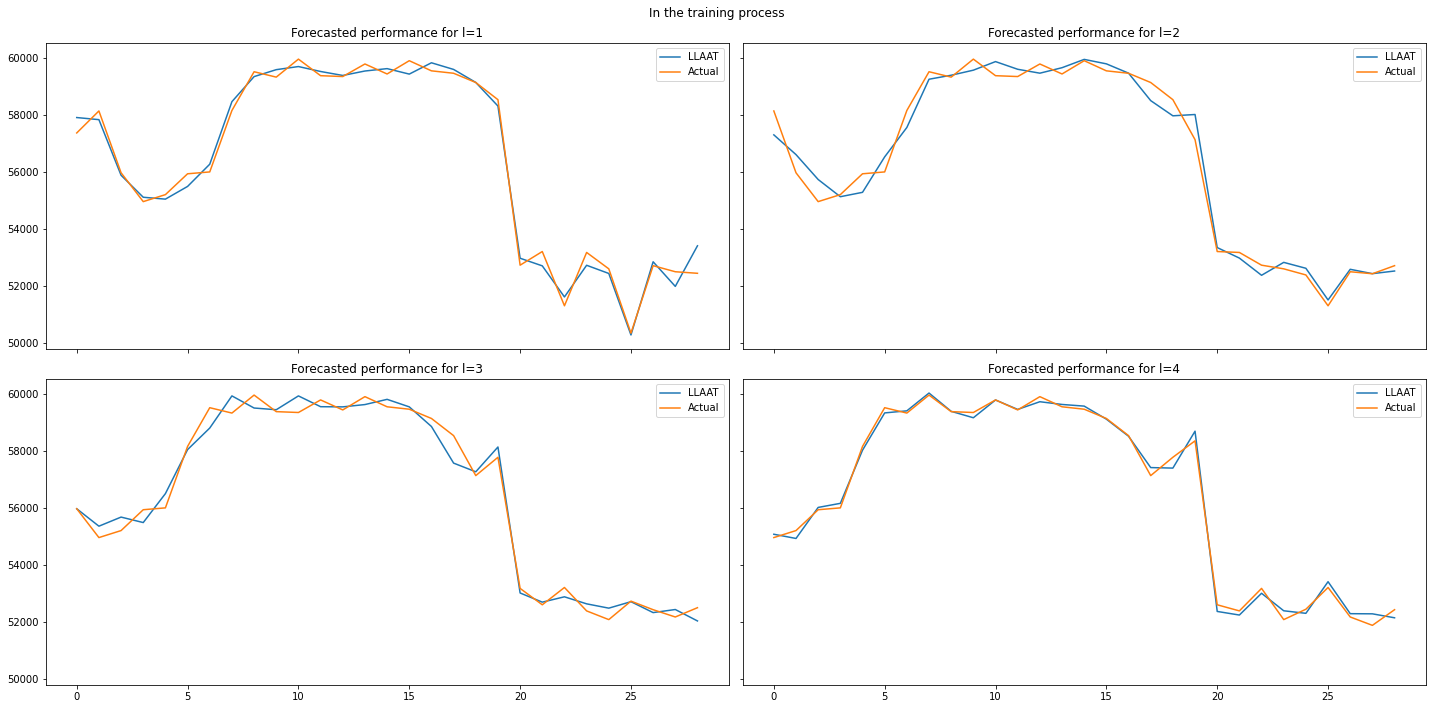

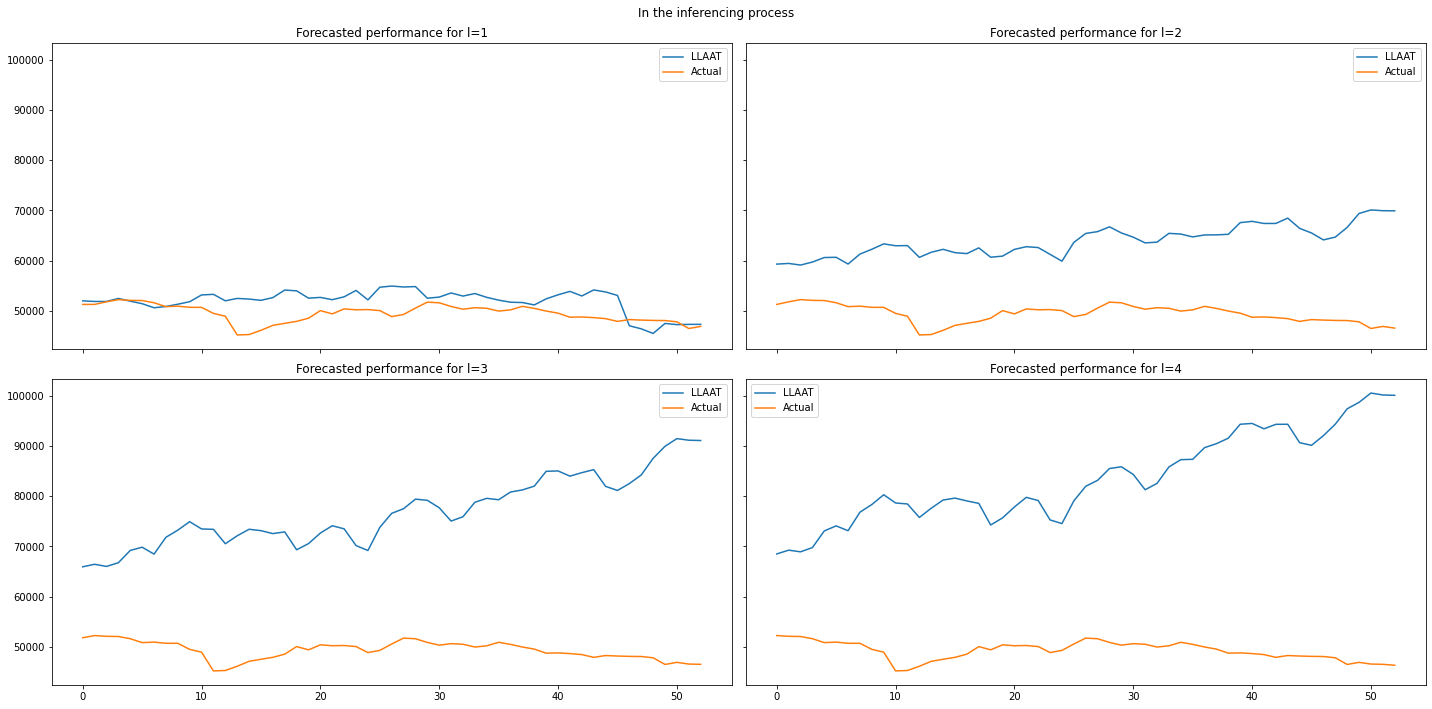

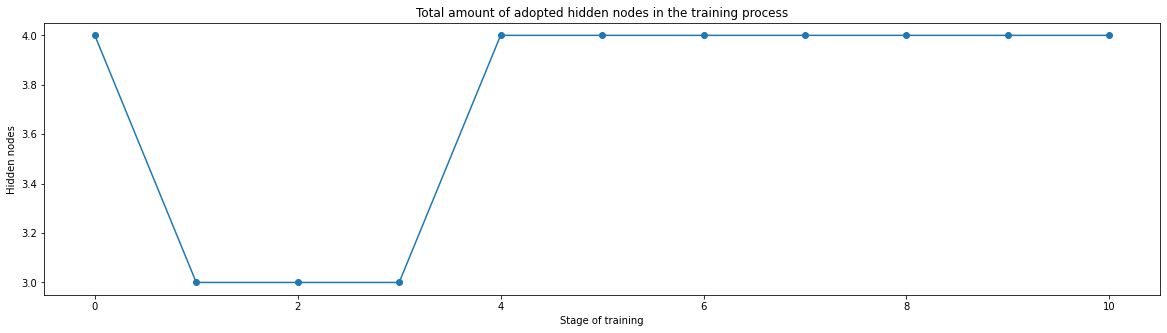

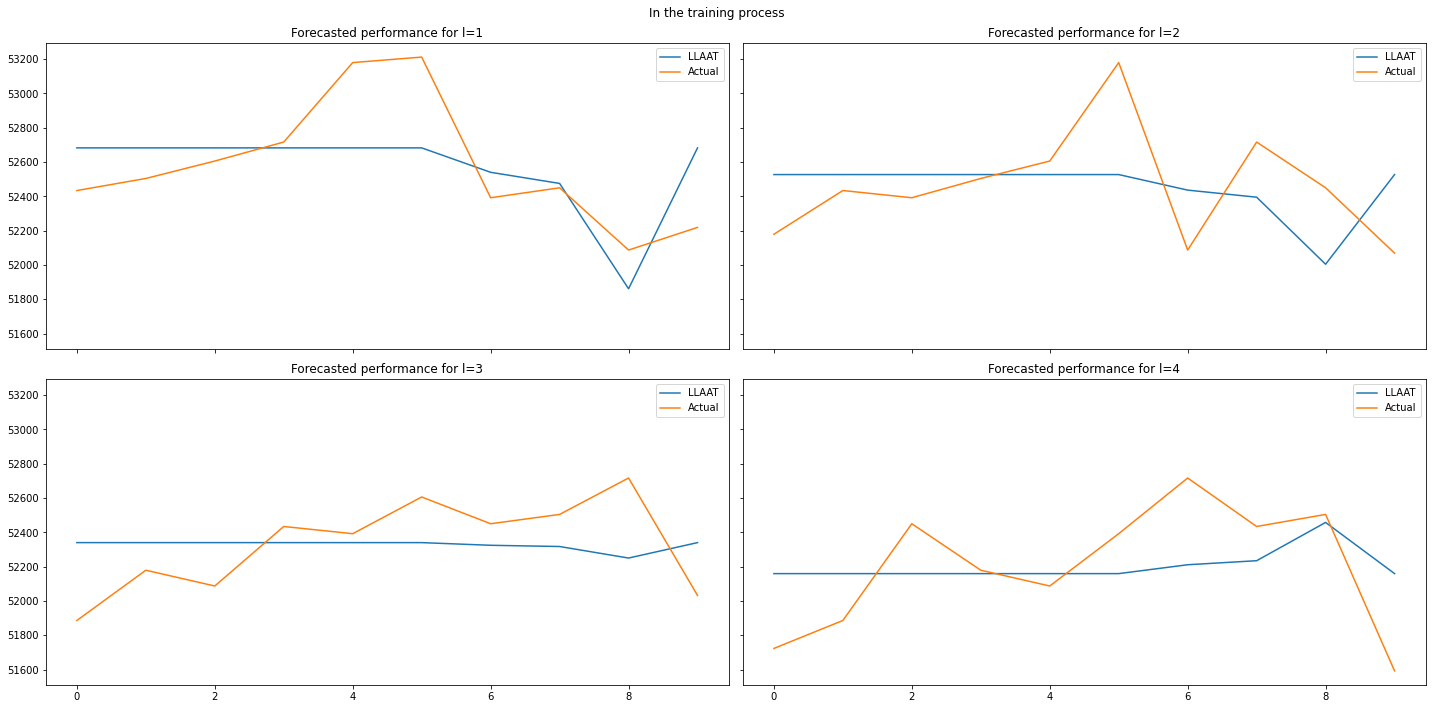

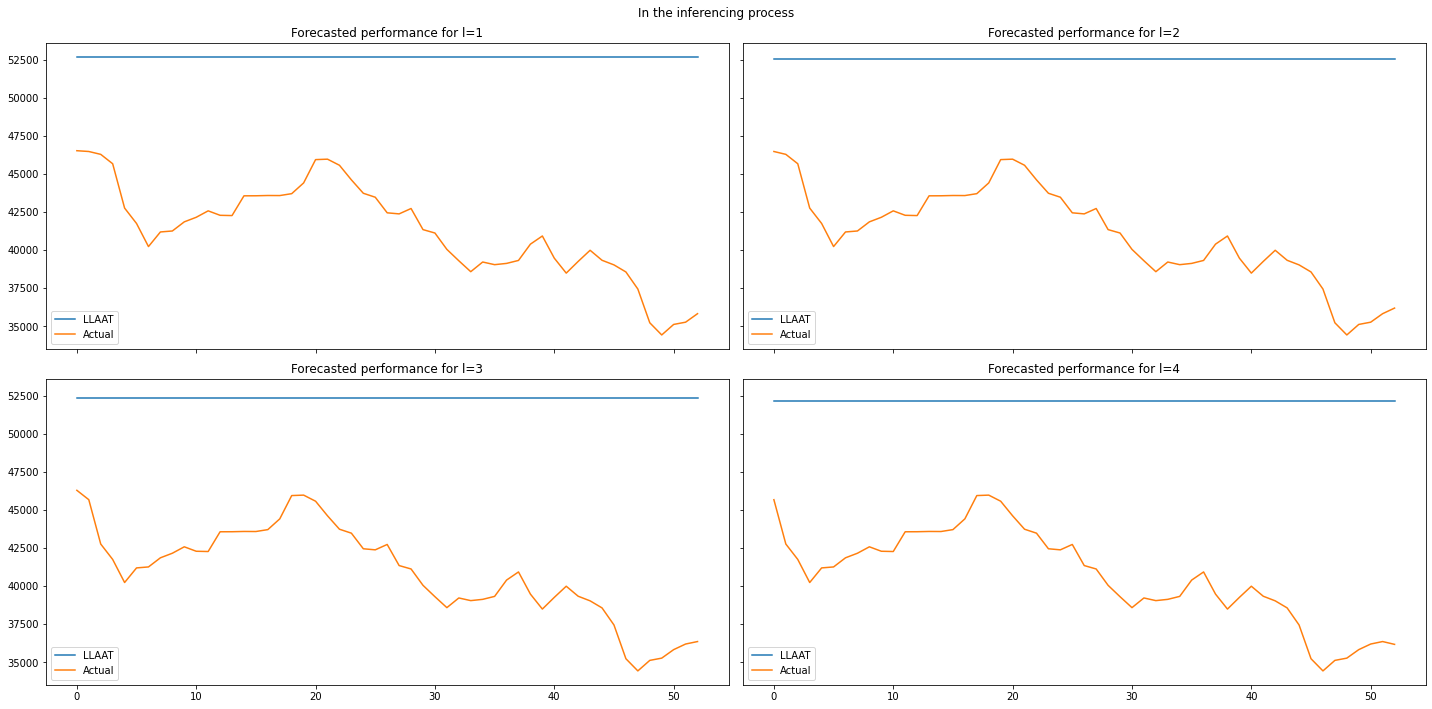

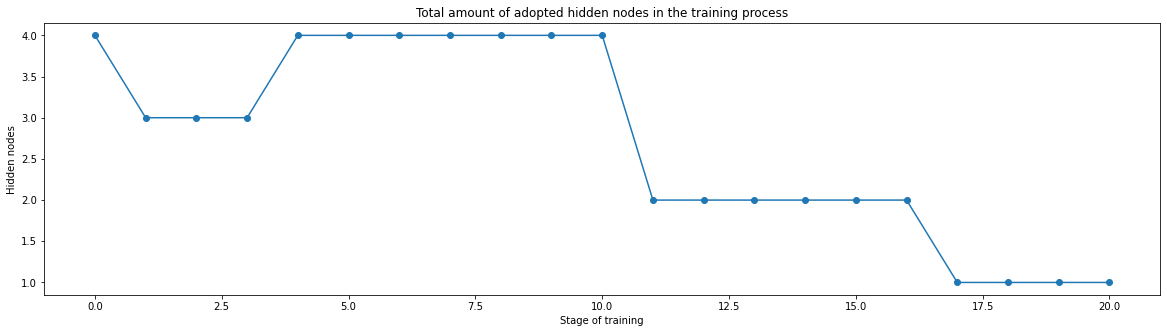

In [141]:
x_data, y_data = get_data(4)

data = range(x_data.shape[0])
# window_size => the length of training block
window_size = 106
# step_window => step size of each window
step_window = 53
# the split data
splits = []

## Moving window mechnism
for i in range(window_size, len(data), step_window):
    train = np.array(data[i-window_size:i])
    test = np.array(data[i:i+step_window])
    splits.append(('TRAIN:', train, 'TEST:', test))

## Record program start time
start = time.time()
# for i in range(len(splits)):
for i_block in range(2):
    block_start = time.time()
    ## Record the number of each step
    nb_step4 = 0
    nb_step6_1 = 0
    nb_step6_2 = 0
    print("The <<%d>> Block" %i_block)
#     print("The training block\n", y_data[splits[i_block][1]])
#     print("The testing block\n", y_data[splits[i_block][3]])
    
    x_train = x_data[splits[i_block][1]]
    x_test = x_data[splits[i_block][3]]
    y_train = y_data[splits[i_block][1]]
    y_test = y_data[splits[i_block][3]]
    
    x_train_scaled = torch.FloatTensor(sc.fit_transform(x_train))
    x_test_scaled = torch.FloatTensor(sc.transform(x_test))
    y_train_scaled = torch.FloatTensor(sc.fit_transform(y_train))
    
    # 如果是第一個 Block的話
    if i_block == 0:
        initial_x = torch.FloatTensor(x_train_scaled[:x_train_scaled.shape[1]+1])
        initial_y = torch.FloatTensor(y_train_scaled[:x_train_scaled.shape[1]+1])
        
        x_train_scaled = torch.FloatTensor(x_train_scaled[x_train_scaled.shape[1]+1:])
        y_train_scaled = torch.FloatTensor(y_train_scaled[x_train_scaled.shape[1]+1:])
        
        
        network = Network(4,initial_x,initial_y)
        initializing(network, initial_x, initial_y)
        print("<<Initializing後看一下差異>>")
        yo,loss = network.forward()
        print(torch.abs(network.y-yo))
    
#     for i in range(round(x_train_scaled.shape[0]*0.9624,0)):
    for i in range(10):
        
        if i_block == 0:
            print("現在訓練到第幾筆資料: %d"%(i+x_train_scaled.shape[1]+2))
        
        else:
            print("現在訓練到第幾筆資料: %d"%(i+1))
        
        print("X 資料",x_train_scaled.shape)
        print("Y 資料",y_train_scaled.shape)
        
        sorted_index = selecting(network, x_train_scaled, y_train_scaled)
        
        if i==0 and i_block > 0:
            print("除了N=0外，第一筆資料")
            network.setData(x_train_scaled[sorted_index[0]].reshape(1,-1), y_train_scaled[sorted_index[0]].reshape(1,-1))
        
        else:    
        ## Add new data for training
            network.addData(x_train_scaled[sorted_index[0]], y_train_scaled[sorted_index[0]])
        
        print("現在要進去模型的數據，索引%d，y="%(sorted_index[0]),y_train_scaled[sorted_index[0]].data)
        print("目前模型的Data",network.x.shape)
        
        x_train_scaled = np.delete(x_train_scaled, sorted_index[0], 0)
        y_train_scaled = np.delete(y_train_scaled, sorted_index[0], 0)

        print("<<差異>>")
        yo,loss = network.forward()
        print(torch.abs(network.y-yo))


        if not torch.all(torch.abs(network.y-yo)<network.threshold_for_error):

            network.acceptable = False
            network = matching(network)

            print("<<Matching後看一下差異>>")
            yo,loss = network.forward()
            print(torch.abs(network.y-yo))

            if network.acceptable == False:
                cramming(network)

                print("<<Cramming後看一下差異>>")
                yo,loss = network.forward()
                print(torch.abs(network.y-yo))
                nb_step6_2 += 1

            else:
                nb_step6_1 += 1

        else:
            nb_step4 += 1

        network = reorganizing(network)
        network.nb_node_acceptable = torch.cat([network.nb_node_acceptable, torch.IntTensor([network.linear1.bias.data.shape[0]])],0)
        print(network.nb_node_acceptable)
        print("<<Reorganizing後看一下差異>>")
        yo,loss = network.forward()
        print(torch.abs(network.y-yo))
        print("到第 %d 資料累積花費時間"%(i+x_train_scaled.shape[1]+2),time.time()-start)
        print("使用裝置",(list(network.parameters())[0].device))
        print("-"*90)
    
    block_end = time.time()
    print("到第 %d 個區塊累積花費時間"%(i_block+1),block_end-block_start)
    print("<<The performance of %d block>>"%(i_block+1))
    
    validation(network, nb_step4, nb_step6_1, nb_step6_2, x_test_scaled, y_test, block_start, block_end)
    end = time.time()

### Main function. Construct a instance of network
- trained through the matching module, reorganizing module, and cramming module

In [65]:
## Record program start time
start = time.time()

## Record the number of each step
nb_step4 = 0
nb_step6_1 = 0
nb_step6_2 = 0

x_train, x_test, y_train, y_test = get_data(4)

x_train = torch.FloatTensor(sc.fit_transform(x_train))
x_test = torch.FloatTensor(sc.transform(x_test))
y_train = torch.FloatTensor(sc.fit_transform(y_train))

initial_x = torch.FloatTensor(x_train[:x_train.shape[1]+1])
initial_y = torch.FloatTensor(y_train[:x_train.shape[1]+1])

# initial_x = torch.FloatTensor(np.round(x_train[:x_train.shape[1]+1],0))
# initial_y = torch.FloatTensor(np.round(y_train[:x_train.shape[1]+1],0))

x_train = torch.FloatTensor(x_train[x_train.shape[1]+1:])
y_train = torch.FloatTensor(y_train[x_train.shape[1]+1:])

network = Network(4,initial_x,initial_y)
initializing(network, initial_x, initial_y)
print("<<Initializing後看一下差異>>")
yo,loss = network.forward()
print(torch.abs(network.y-yo))

for i in range(0, 10):
    
    print("現在訓練到第幾筆資料: %d"%(i+x_train.shape[1]+2))
    sorted_index = selecting(network, x_train, y_train)
    ## Add new data for training
    network.addData(x_train[sorted_index[0]], y_train[sorted_index[0]])
    print("現在要進去模型的數據，索引%d，y="%(sorted_index[0]),y_train[sorted_index[0]].data)
    x_train = np.delete(x_train, sorted_index[0], 0)
    y_train = np.delete(y_train, sorted_index[0], 0)
    
    print("<<差異>>")
    yo,loss = network.forward()
    print(torch.abs(network.y-yo))
    
#     print("<<Before>>")
#     yo,loss = network.forward()
#     print(network.learning_rate)
#     print(network.linear1.weight)
#     print(torch.abs(yo-network.y))
#     print(network.state_dict())

    if not torch.all(torch.abs(network.y-yo)<network.threshold_for_error):
        
        network.acceptable = False
        network = matching(network)
    
        print("<<Matching後看一下差異>>")
        yo,loss = network.forward()
        print(torch.abs(network.y-yo))
    
        if network.acceptable == False:
            cramming(network)

            print("<<Cramming後看一下差異>>")
            yo,loss = network.forward()
            print(torch.abs(network.y-yo))
            nb_step6_2 += 1
        
        else:
            nb_step6_1 += 1
        
    else:
        nb_step4 += 1
    
    network = reorganizing(network)
    network.nb_node_acceptable = torch.cat([network.nb_node_acceptable, torch.IntTensor([network.linear1.bias.data.shape[0]])],0)
    print(network.nb_node_acceptable)
    print("<<Reorganizing後看一下差異>>")
    yo,loss = network.forward()
    print(torch.abs(network.y-yo))
    print("第 %d 資料花費時間"%(i+x_train.shape[1]+2),time.time()-start)
    print("使用裝置",(list(network.parameters())[0].device))
    print("-"*90)
    
    #     yo,loss = network.forward()
#     print(torch.abs(network.y-yo))
print("使用裝置",(list(network.parameters())[0].device))
end = time.time()
#     matching(network)
# print("<<Main>>")
# print(network.state_dict())

Initializing module
<<Initializing後看一下差異>>
tensor([[    0.0000,     0.0000,     0.0000,     0.0000],
        [    0.0000,     0.0000,     0.0000,     0.0000],
        [    0.0000,     0.0000,     0.0000,     0.0000],
        [    0.0000,     0.0000,     0.0000,     0.0000],
        [    0.0000,     0.0000,     0.0000,     0.0000],
        [    0.0000,     0.0000,     0.0000,     0.0000],
        [    0.0000,     0.0000,     0.0000,     0.0000],
        [    0.0000,     0.0000,     0.0000,     0.0000],
        [    0.0000,     0.0000,     0.0000,     0.0000],
        [    0.0000,     0.0000,     0.0000,     0.0000],
        [    0.0000,     0.0000,     0.0000,     0.0000],
        [    0.0000,     0.0000,     0.0000,     0.0000],
        [    0.0000,     0.0000,     0.0000,     0.0000],
        [    0.0000,     0.0000,     0.0000,     0.0000],
        [    0.0000,     0.0000,     0.0000,     0.0000],
        [    0.0000,     0.0000,     0.0000,     0.0000],
        [    0.0000,     0.00

/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


Matching finished - the network is Unacceptable
Number of enlarge: 1931
Number of shrink: 994
是不是可以不要你: False
Cannot drop out the nero number: 1 / 5
<<Regularizing module>>
Regularizing結束
Number of enlarge: 0
Number of shrink: 4
因為沒有顧好預測誤差
<<Matching module>>
Matching finished - the network is Unacceptable
Number of enlarge: 3839
Number of shrink: 1969
是不是可以不要你: False
Cannot drop out the nero number: 2 / 5
<<Regularizing module>>
Regularizing結束
Number of enlarge: 0
Number of shrink: 4
因為沒有顧好預測誤差
<<Matching module>>
Matching finished - the network is Unacceptable
Number of enlarge: 16093
Number of shrink: 8233
是不是可以不要你: False
Cannot drop out the nero number: 3 / 5
<<Regularizing module>>
Regularizing結束
Number of enlarge: 0
Number of shrink: 4
因為沒有顧好預測誤差
<<Matching module>>
Matching finished - the network is acceptable
Number of enlarge: 157
Number of shrink: 62
是不是可以不要你: True
Drop out the nero number: 4 / 5
<<Regularizing module>>
第"1"回合是成功執行regularizing
第"2"回合是成功執行regularizing
第"3"回合是成

[46208. 46208. 46208. 46208.]
<<Training step>>
The training time(s): 11112.719745874405
<<The percentage of each step>>
Step 4: 0.62%
Step 6.1: 0.15%
Step 6.2: 0.23%
------------------------------------------------------------
Total frequency of cramming occurrences: 3
------------------------------------------------------------
The amount of hidden node that be pruned: 1
------------------------------------------------------------
The amount of adopted hidden nodes: 3
------------------------------------------------------------
<<Accuracy in training step>>
The accuracy for l = 1: 100.0%
The accuracy for l = 2: 100.0%
The accuracy for l = 3: 100.0%
The accuracy for l = 4: 100.0%
------------------------------------------------------------
<<Accuracy in inferencing step>>
The accuracy for l = 1: 11.3%
The accuracy for l = 2: 22.6%
The accuracy for l = 3: 0.0%
The accuracy for l = 4: 0.0%


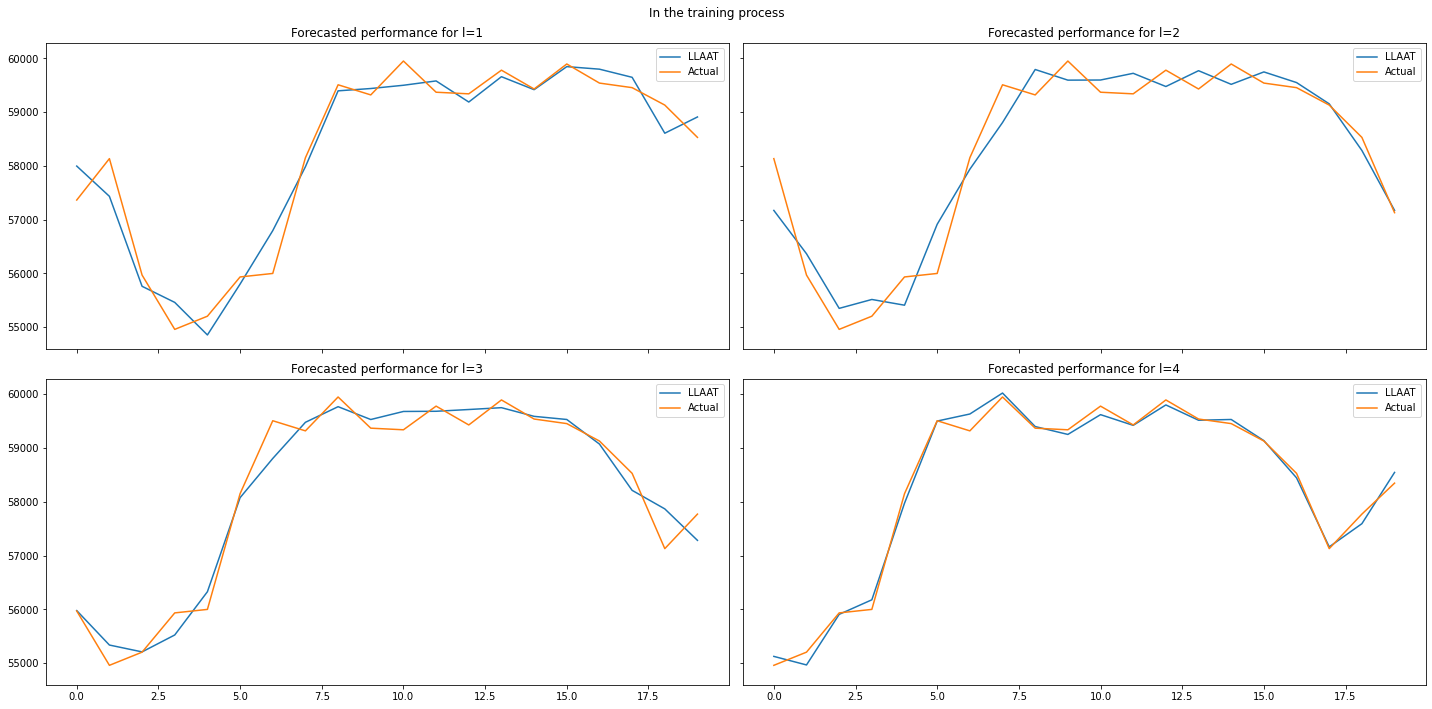

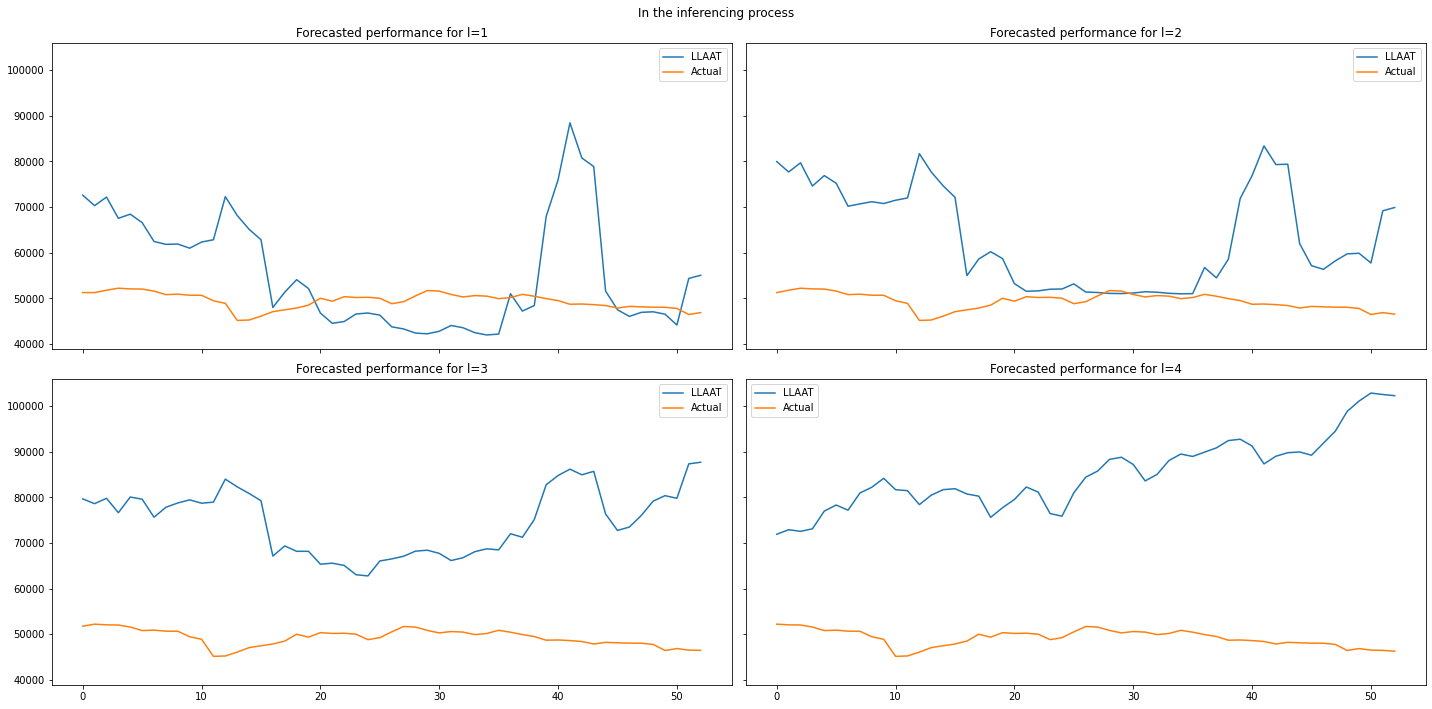

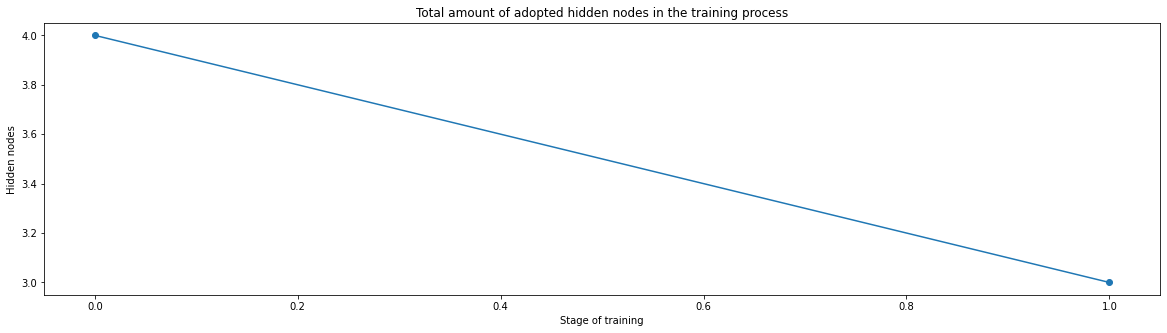

In [136]:
validation(network, nb_step4, nb_step6_1, nb_step6_2, x_test_scaled, y_test, start, end)

[34435. 34435. 34435. 34435.]
<<Training step>>
The training time(s): 1408.7374897003174
<<The percentage of each step>>
Step 4: 0.80%
Step 6.1: 0.10%
Step 6.2: 0.10%
------------------------------------------------------------
Total frequency of cramming occurrences: 1
------------------------------------------------------------
The amount of hidden node that be pruned: 4
------------------------------------------------------------
The amount of adopted hidden nodes: 3
------------------------------------------------------------
<<Accuracy in training step>>
The accuracy for l = 1: 100.0%
The accuracy for l = 2: 100.0%
The accuracy for l = 3: 100.0%
The accuracy for l = 4: 100.0%
------------------------------------------------------------
<<Accuracy in inferencing step>>
The accuracy for l = 1: 0.0%
The accuracy for l = 2: 0.0%
The accuracy for l = 3: 0.0%
The accuracy for l = 4: 0.0%


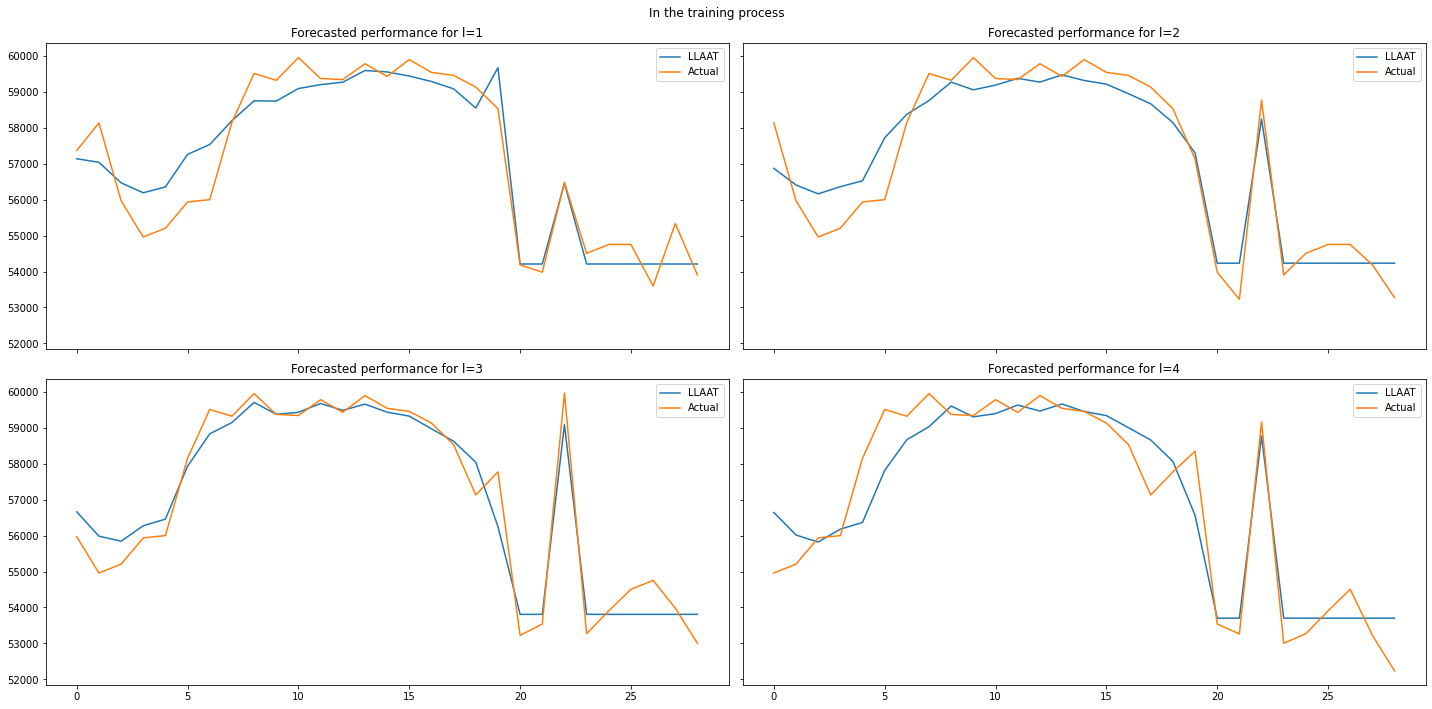

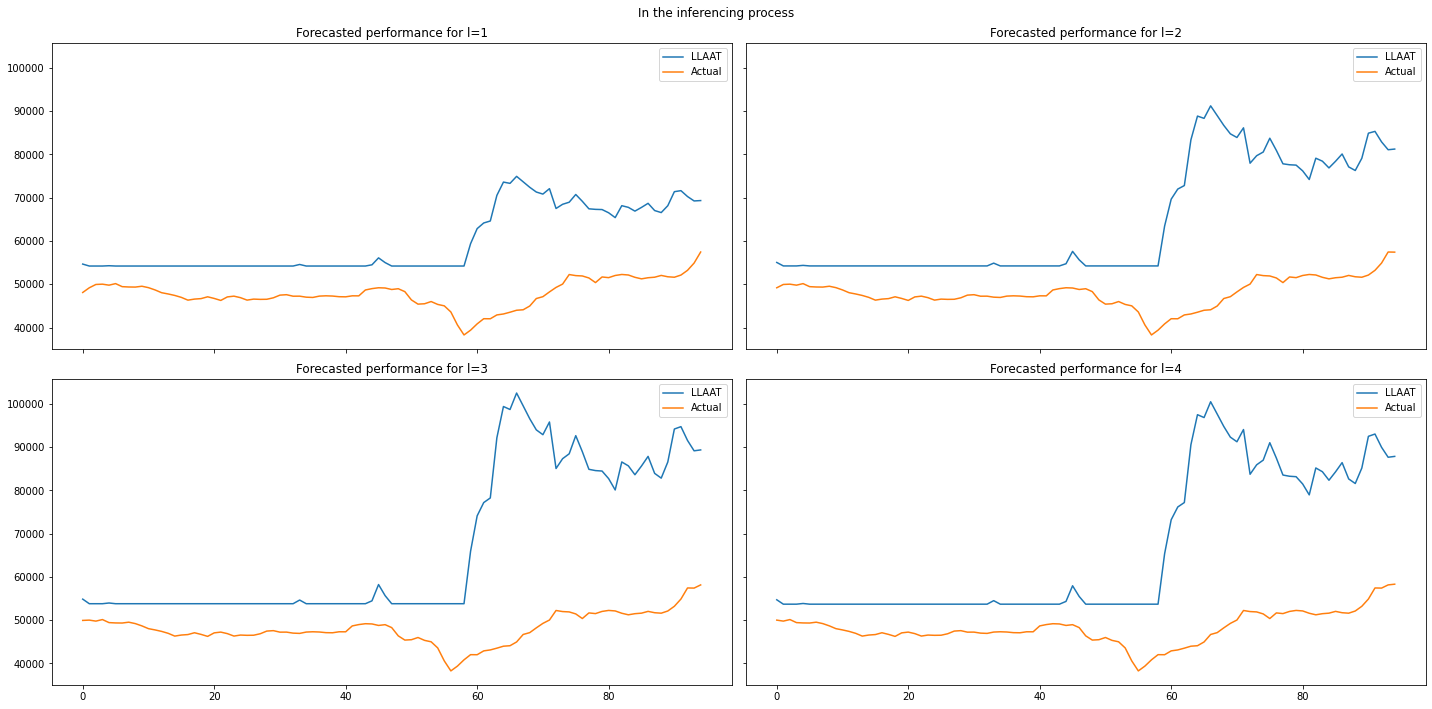

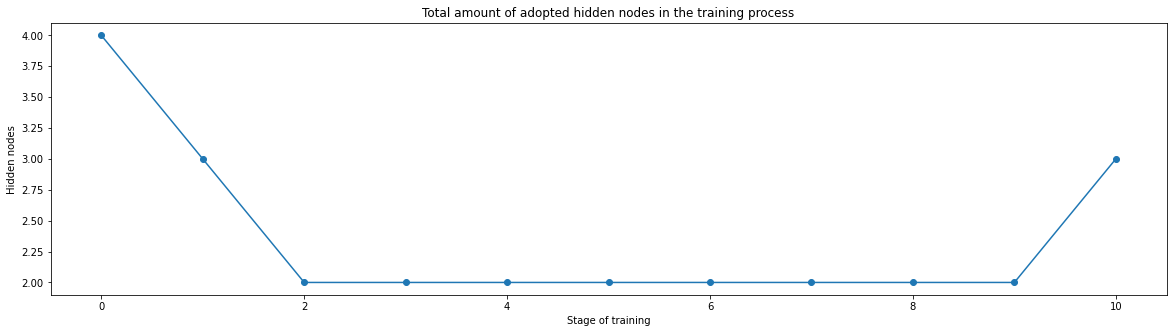

In [66]:
validation(network, nb_step4, nb_step6_1, nb_step6_2, x_test, y_test, start, end)

In [ ]:
# def accuracy_cacl(pred_value, actual_value):
    
# #     yo, loss, tape = network.forward()
#     accuracy = []

#     for i in range(pred_value.shape[1]):
        
#         correct_times = torch.nonzero(torch.abs(pred_value[:,i].data - actual_value[:,i].data) < 2000)
#         accuracy.append(correct_times.shape[0]/pred_value.shape[0])   
        
#     return accuracy

In [ ]:
# # yo,loss = network.forward()
# accuracy_cacl(yo, network.y)

# torch.nonzero(yo[:,1].data-network.y[:,1].data< 2000).shape[0]

In [ ]:
# plot_result("Training", yo, network.y)